In [49]:
import numpy as np
from scipy.signal import savgol_filter
from math import ceil
from scipy.signal import csd
from scipy.optimize import least_squares
from itertools import product

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')



class noise(object):
    
    
    def __init__(self, traces, sampleRate, channNames, traceGain = 1.0, name = None, freqs = None, time = None \
                 , PSD = None , real_PSD = None, imag_PSD = None, corrCoeff = None, unCorrNoise = None \
                 , corrNoise = None, real_CSD = None, imag_CSD = None, real_CSD_std = None, imag_CSD_std = None \
                 , freqs_CSD = None):
        self.traces = traces # 3d numpy array. dimention zero is number of traces, d-1 is channel number, 
        #d-3 is number of data points per trace
        self.sampleRate = sampleRate
        self.channNames = channNames
        self.time = time # array of x-values in units of time [sec]
        self.name = name
        
         #list of channel names
        self.traceGain = traceGain #convertion of trace amplitude from ADC bins to amperes 
        self.freqs = np.fft.rfftfreq(self.traces.shape[2],d = 1/sampleRate)
        self.PSD = PSD
        self.real_PSD = real_PSD
        self.imag_PSD = imag_PSD
        self.corrCoeff = corrCoeff
        self.unCorrNoise = unCorrNoise
        self.corrNoise = corrNoise
        self.real_CSD = real_CSD
        self.imag_CSD = imag_CSD
        self.real_CSD_std = real_CSD_std
        self.imag_CSD_std = imag_CSD_std
        self.freqs_CSD = freqs_CSD
        
        
        
        
    
    def set_freqs(self, freqs):
        self.freqs = freqs
    def set_traceGain(self, traceGain):
        self.traceGain = traceGain
    def set_sampleRate(self, sampleRate):
        self.sampleRate = sampleRate
    def set_channNames(self, channNames):
        self.channNames = channNames
    def set_name(self, name):
        self.name = name
        
        
    
        
        
    #def calculate_freqs(self):
    #    dt = 1/self.sampleRate
    #    self.freqs = np.fft.rfftfreq(self.traces.shape[2],d = dt)

    
    def caclulate_PSD(self): 
        # get shape of traces to use for iterating
        traceShape = self.traces.shape
        #check if length of individual trace is odd of even
        if traceShape[2] % 2 != 0:
            lenPSD = int((traceShape[2] + 1)/2)
        else:
            lenPSD = int(traceShape[2]/2 + 1)
            
        # initialize empty numpy array to hold the PSDs 
        PSD = np.empty(shape = (traceShape[1], lenPSD))
        real_PSD = np.empty(shape = (traceShape[1], lenPSD))
        imag_PSD = np.empty(shape = (traceShape[1], lenPSD))
 
        fft = np.fft.rfft(self.traces)
        PSD_chan = np.abs(fft)**2
        real_PSD_chan = np.real(fft)**2
        imag_PSD_chan = np.imag(fft)**2
        # take the average of the PSD's for each trace, normalize, and fold over the 
        # negative frequencies since they are symmetric
        PSD = np.mean(PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate) 
        real_PSD = np.mean(real_PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate)
        imag_PSD = np.mean(real_PSD_chan, axis = 0)*2.0/(traceShape[2]*self.sampleRate)  
               
        self.PSD = PSD
        self.real_PSD = real_PSD
        self.imag_PSD = imag_PSD
        
        
    def calculate_corrCoeff(self):
        nsizeMatrix = self.traces.shape[1]
        if self.traces.shape[2] % 2 != 0:
            lenPSD = int((self.traces.shape[2] + 1)/2)
        else:
            lenPSD = int(self.traces.shape[2]/2 + 1)
                
        nDataPoints = self.traces.shape[0]
        #initialize empty array                           
        corr_coeff = np.empty(shape=(lenPSD,nsizeMatrix,nsizeMatrix)) 
        

        traces_fft_chan = np.abs(np.fft.rfft(traces))
        traces_fft_chan = np.swapaxes(traces_fft_chan, 0,1)
        for n in range(lenPSD):
            corr_coeff[n] = np.corrcoef(traces_fft_chan[:,:,n])
        
        self.corrCoeff = np.swapaxes(corr_coeff, 0, 2)
        
        
    
        
    ############# plotting
    def plot_PSD(self, lgc_overlay = True, lgcSave = False, savePath = None):
        '''
        Function to plot the noise spectrum referenced to the TES line in units of Amperes/sqrt(Hz)
        
        Input parameters:
        lgc_overlay: boolian value. If True, PSD's for all channels are overlayed in a single plot, 
                     if False, each PSD for each channel is plotted in a seperate subplot
        lgcSave: boolian value. If True, the figure is saved in the user provided directory
        savePath: absolute path for the figure to be saved
        
        Returns:
        None
        '''
        
        
        
        if lgc_overlay:
            sns.set_context('notebook')
            plt.figure()
            plt.xlabel('frequency [Hz]')
            plt.ylabel(r'Input Referenced Noise [A/$\sqrt{\mathrm{Hz}}$]')
            plt.grid(which = 'both')
            for ichan, channel in enumerate(self.channNames):
                plt.loglog(self.freqs[1:], np.sqrt(self.PSD[ichan][1:]), label = channel)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()
            if lgcSave:
                try:
                    plt.savefig(savePath+self.name.replace(" ", "_")+'_PSD_overlay.png')
                except:
                    print('Invalid save path. Figure not saved')
            
    
    
        else:
            sns.set_context('poster', font_scale = 1.9)
            num_subplots = len(self.channNames)
            nRows = int(ceil(num_subplots/2))
            nColumns = 2

            fig, axes = plt.subplots(nRows, nColumns, figsize = (6*num_subplots,6*num_subplots)) 
            plt.suptitle(self.name,  fontsize=40)
            for ii in range(nRows*2):
                if ii < 4:
                    iRow = ii
                    jColumn = 0
                else:
                    iRow = ii - 4
                    jColumn = 1
                if ii < num_subplots:    
                    axes[iRow,jColumn].set_title(self.channNames[ii])
                    axes[iRow,jColumn].set_xlabel('frequency [Hz]')
                    axes[iRow,jColumn].set_ylabel(r'Input Referenced Noise [A/$\sqrt{\mathrm{Hz}}$]')
                    axes[iRow,jColumn].grid(which = 'both')
                    axes[iRow,jColumn].loglog(self.freqs[1:], np.sqrt(self.PSD[ii][1:]))
                else:
                    axes[iRow,jColumn].axis('off')


            plt.tight_layout() 
            plt.subplots_adjust(top=0.95)
            plt.show()

            if lgcSave:
                try:
                    plt.savefig(savePath+self.name.replace(" ", "_")+'_PSD_subplot.png')
                except:
                    print('Invalid save path. Figure not saved')
            
    def plot_corrCoef(self, lgcSave = False, savePath = None):
        '''
        Function to plot the cross channel correlation coefficients. Since there is typically few traces,
        the correlations are often noisy. a savgol_filter is used to smooth out some of the noise
        
        Input parameters:
        lgcSave: boolian value. If True, the figure is saved in the user provided directory
        savePath: absolute path for the figure to be saved
        
        Returns:
        None
        '''
        sns.set_context('notebook')
        plt.figure()
        plt.title('{} \n Cross Channel Correlation Coefficients'.format(self.name) )
        for ii in range(self.corrCoeff.shape[0]):
            for jj in range(self.corrCoeff.shape[1]):
                if ii > jj:
                    label = '{} - {}'.format(self.channNames[ii],self.channNames[jj])
                    plt.plot(self.freqs, savgol_filter(self.corrCoeff[ii][jj], 51,3), label = label, alpha = .5)
                    plt.xscale('log')
        plt.xlabel('frequency [Hz]')
        plt.ylabel(r'Correlation Coeff [COV(x,y)/$\sigma_x \sigma_y$]')
        plt.grid(which = 'both')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        if lgcSave:
                try:
                    plt.savefig(savePath+self.name.replace(" ", "_")+'_corrCoeff.png')
                except:
                    print('Invalid save path. Figure not saved')
            
######################### decorrelation of noise ##########
    def calculate_CSD(self, lgc_full_CSD =  True, lenCSD = 256):
        
        
        traceShape = self.traces.shape
        if lgc_full_CSD:
            lenCSD = traceShape[2]
        else:
            lenCSD = lenCSD
            
        if lenCSD % 2 != 0:
            nFreqs = int((lenCSD + 1)/2)
        else:
            nFreqs = int(lenCSD/2 + 1)
       
        nRows = traceShape[1]
        nTraces = traceShape[0]
           
        # initialize the S_ij matrix
        trace_CSD = np.zeros(shape=(nRows,nRows,nTraces,nFreqs),dtype = np.float64)
        
        real_CSD_mean = np.zeros(shape=(nRows,nRows,nFreqs),dtype = np.float64)
        imag_CSD_mean = np.zeros(shape=(nRows,nRows,nFreqs),dtype = np.float64)
        
        real_CSD_std = np.zeros(shape=(nRows,nRows,nFreqs),dtype = np.float64)
        imag_CSD_std = np.zeros(shape=(nRows,nRows,nFreqs),dtype = np.float64)
        
        for iRow, jColumn in product(list(range(nRows)),repeat = 2):
            for n in range(nTraces):
                freqs ,temp_CSD = csd(self.traces[n,iRow,:],self.traces[n,jColumn,:] \
                                           , nperseg = lenCSD, fs = self.sampleRate, nfft = lenCSD )            

                trace_CSD[iRow][jColumn][n] = temp_CSD

            real_CSD_mean[iRow][jColumn] = np.real(np.mean(trace_CSD[iRow][jColumn],axis = 0))
            imag_CSD_mean[iRow][jColumn] = np.imag(np.mean(trace_CSD[iRow][jColumn],axis = 0))   
            real_CSD_std[iRow][jColumn] = np.real(np.std(trace_CSD[iRow][jColumn],axis = 0))
            imag_CSD_std[iRow][jColumn] = np.imag(np.std(trace_CSD[iRow][jColumn],axis = 0))
            
        self.freqs_CSD = freqs    
        self.real_CSD = real_CSD_mean
        self.imag_CSD = imag_CSD_mean
        self.real_CSD_std = real_CSD_std
        self.imag_CSD_std = imag_CSD_std
        
    def calculate_unCorrelated_noise(self, lgc_full_CSD =  True, lenCSD = 256):
        
        
        if self.real_CSD == None:
            print('calculating CSD')
            self.calculate_CSD(lgc_full_CSD , lenCSD )
            
        traceShape = self.traces.shape
        nRows = traceShape[1]
        nTraces = traceShape[0]
        freqs = self.freqs_CSD
        #results = np.zeros(shape = (freqs.shape[0]))
        results = []
        nFail = 0
        
        
        
        def equations(parameters,lgcReal, i , j):
            reA = parameters[0:nRows]
            imA = parameters[nRows:nRows*2]
            sigR = parameters[nRows*2:]                        
            if lgcReal:
                if i == j:
                    return 2.0*(reA[i]*reA[j] + imA[i]*imA[j]) + 2.0*sigR[i]
                else:
                    return 2.0*(reA[i]*reA[j] + imA[i]*imA[j])
            else:
                return 2.0*(imA[i]*reA[j]-reA[i]*imA[j])
        
        def residual(parameters):            
            res = list()            
            for iRow in range(nRows):
                for jColumn in range(nRows):
                    weight = (self.real_CSD_std[iRow][jColumn][iFreq])/np.sqrt(nTraces)                                         
                    if iRow >= jColumn:                                                                                                   
                        temp = (self.real_CSD[iRow][jColumn][iFreq] - equations(parameters,  True, iRow,jColumn))                                         
                    else:                        
                        temp = (self.imag_CSD[iRow][jColumn][iFreq] - equations(parameters,  False, iRow,jColumn))                                                                        
                    res.append(temp/weight)
            res_ret = np.asarray(res)                      
            return res_ret
    
        def get_guess(iFreq):
            '''
            Returns a list for the initial guess p0 and bounds, for a given frequency
            '''        
            np0 = nRows*3        
            p0 = np.zeros(shape = np0, dtype = np.float64)        
            reAGuess = list()
            imAGuess = list()
            sigGuess = list()        
            mean_list_Re = list()
            mean_list_Im = list()        
            for iRow in range(nRows):
                for jColumn in range(nRows):
                    if iRow != jColumn:
                        temp_Re = self.real_CSD[iRow][jColumn][iFreq]
                        temp_Im = self.imag_CSD[iRow][jColumn][iFreq]                                           
                        mean_list_Re.append(temp_Re)
                        mean_list_Im.append(temp_Im)
            mean_Re = np.mean(mean_list_Re)
            mean_Im = np.mean(mean_list_Im)
            #if mean_Re == 0.0:
            #    mean_Re = 1.e-40
            #if mean_Im == 0.0:
            #    mean_Im = 1.e-40    
            for ii in range(nRows):    
                temp = self.real_CSD[ii][ii][iFreq] - mean_Re
                #if temp < 0.0:
                #    temp = 1e-80  
                reAGuess.append(np.sqrt(mean_Re)/2.)
                imAGuess.append(np.sqrt(mean_Im)/2.)
                sigGuess.append(temp)     
            p0 = np.concatenate((reAGuess,imAGuess,sigGuess))
            bounds_lower = np.zeros(shape = p0.shape, dtype = np.float64)   
            bounds_upper = np.zeros(shape = p0.shape, dtype = np.float64)          
            for iGuess in range(len(p0)):
                upper = p0[iGuess]*1.e7
                if upper == 0.0:
                    upper = 1.e-7     
                bounds_lower[iGuess] = p0[iGuess]/1.e7
                bounds_upper[iGuess] = upper 
            bounds = (bounds_lower,bounds_upper)

            return p0, bounds
    
        for iFreq in range(self.real_CSD.shape[-1]):

            if iFreq % 50 == 0: #to speed up and not print so many times

                percentDoneStr = str(round((iFreq+1)/freqs.shape[0],3)*100.0)

                print('\n Fitting frequency bin ', iFreq , ' out of ',freqs.shape[0])

                print('\n ====== ', percentDoneStr ,'percent Done ================ ')

            p0, bounds = get_guess(iFreq)


            popt1 = least_squares(residual,p0,jac = 'cs',bounds=bounds,x_scale = 'jac' \
                                  ,loss='linear',max_nfev=1000,verbose=0,xtol=1.0e-17,ftol=1.0e-17,f_scale=1.0)

            if not popt1['success']:
                nFail += 1

            results.append(popt1)

        self.unCorrNoise = results
    
    
    
    
    
    
    
    
    
    
    
    
    
    

### Load test traces

In [2]:

import pickle as pkl    
with open('/nervascratch/cwfink/Analysis/Runs/SLAC/Run37/noise_traces_PT_on.pkl', "rb") as f:
        traces = pkl.load(f,fix_imports=True,encoding='latin1')

### Initialize noise object

In [50]:
sampleRate = 625e3
channels = [ 'PCS1' , 'PES1' , 'PFS1' , 'PAS2' , 'PBS2' , 'PES2' , 'PDS2' ]
g124_noise = noise(traces, sampleRate, channels)
g124_noise.set_name('G124 SLAC Run 37 Pulse Tube On')


### Calculate PSD and correlation coefficients

In [10]:

g124_noise.caclulate_PSD()
g124_noise.calculate_corrCoeff()

# Test correlated noise fit


In [51]:
%timeit g124_noise.calculate_CSD()#lgc_full_CSD=False)


/galbadata/analysis/packages/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:249: ComplexWarning: Casting complex values to real discards the imaginary part


1 loop, best of 3: 8.32 s per loop


In [8]:
g124_noise.calculate_unCorrelated_noise(lgc_full_CSD=False)

calculating CSD


/galbadata/analysis/packages/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:249: ComplexWarning: Casting complex values to real discards the imaginary part



 Fitting frequency bin  0  out of  129

 ======  0.8 percent Done ================ 


/galbadata/analysis/packages/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:111: UserWarning: `ftol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`ftol`", EPS))
/galbadata/analysis/packages/anaconda3/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py:114: UserWarning: `xtol` is too low, setting to machine epsilon 2.220446049250313e-16.
  warn(message.format("`xtol`", EPS))



 Fitting frequency bin  50  out of  129

 ======  39.5 percent Done ================ 

 Fitting frequency bin  100  out of  129

 ======  78.3 percent Done ================ 


In [20]:
fit_00 = []
fit_11 = []
fit_22 = []
fit_33 = []

for fit in g124_noise.unCorrNoise:
    fit_00.append(fit['x'][13])
    fit_11.append(fit['x'][14])
    fit_22.append(fit['x'][15])
    fit_33.append(fit['x'][16])

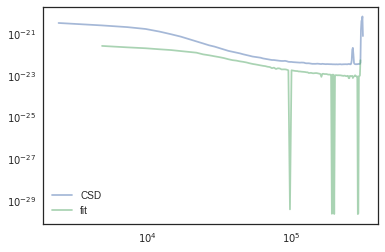

In [30]:
ii = 3
plt.loglog(g124_noise.freqs_CSD[1:], (g124_noise.real_CSD[ii][ii][1:]), label = 'CSD', alpha = .5)
plt.loglog(g124_noise.freqs_CSD[2:-5],fit_33[2:-5], label = 'fit', alpha = 0.5)
plt.legend()


### Test calculation of Cross Spectral Density

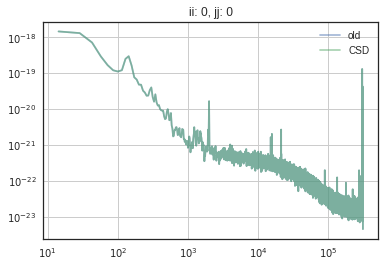

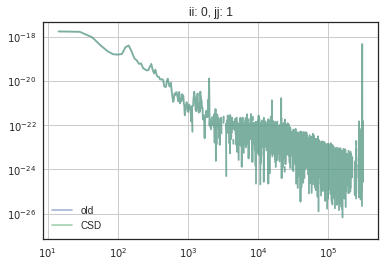

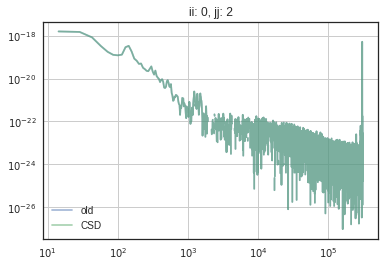

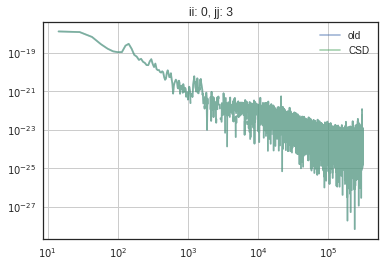

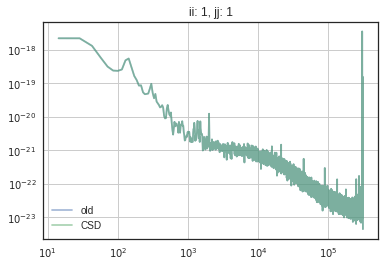

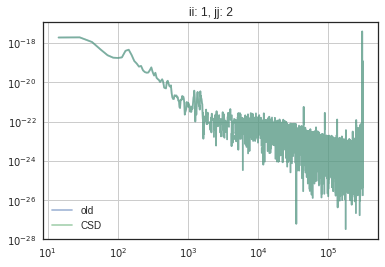

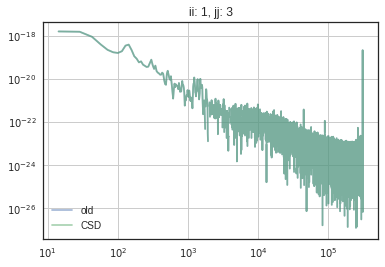

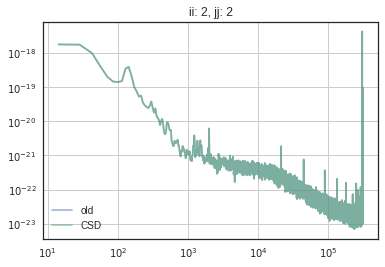

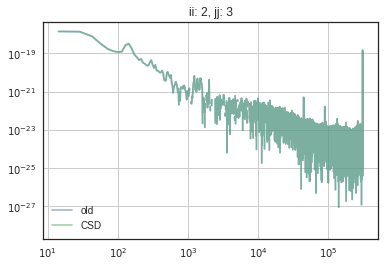

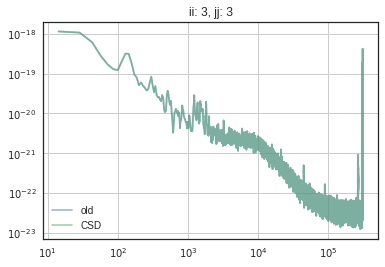

In [44]:
#old = g124_noise.real_CSD
from itertools import combinations_with_replacement
for ii, jj in combinations_with_replacement(range(g124_noise.real_CSD.shape[0] - 3),2  ):

    plt.figure()
    plt.title('ii: {}, jj: {}'.format(ii,jj))
    plt.loglog(g124_noise.freqs_CSD[1:],(old[ii][jj][1:]).clip(0), label = 'old', alpha = .5)
    #plt.loglog(g124_noise.freqs[1:], savgol_filter((g124_noise.real_CSD[ii][jj][1:]).clip(0),31,5), label = 'new', alpha = .5)
    #plt.loglog(g124_noise.freqs[1:], (g124_noise.real_CSD[ii][jj][1:]).clip(0), label = 'CSD', alpha = .5)
    plt.loglog(g124_noise.freqs_CSD[1:], (g124_noise.real_CSD[ii][jj][1:]), label = 'CSD', alpha = .5)

    plt.grid()
    plt.legend()



### Test Plotting of PSD and correlation coefficients

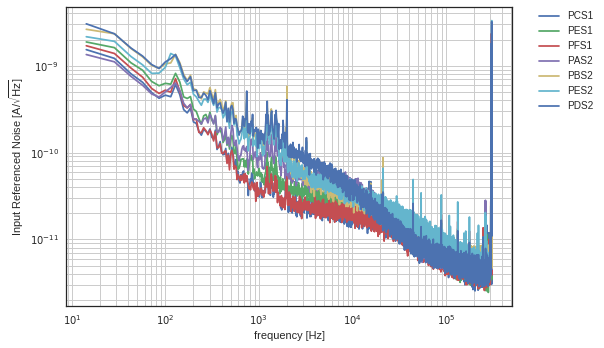

In [45]:
g124_noise.plot_PSD(lgc_overlay=True)

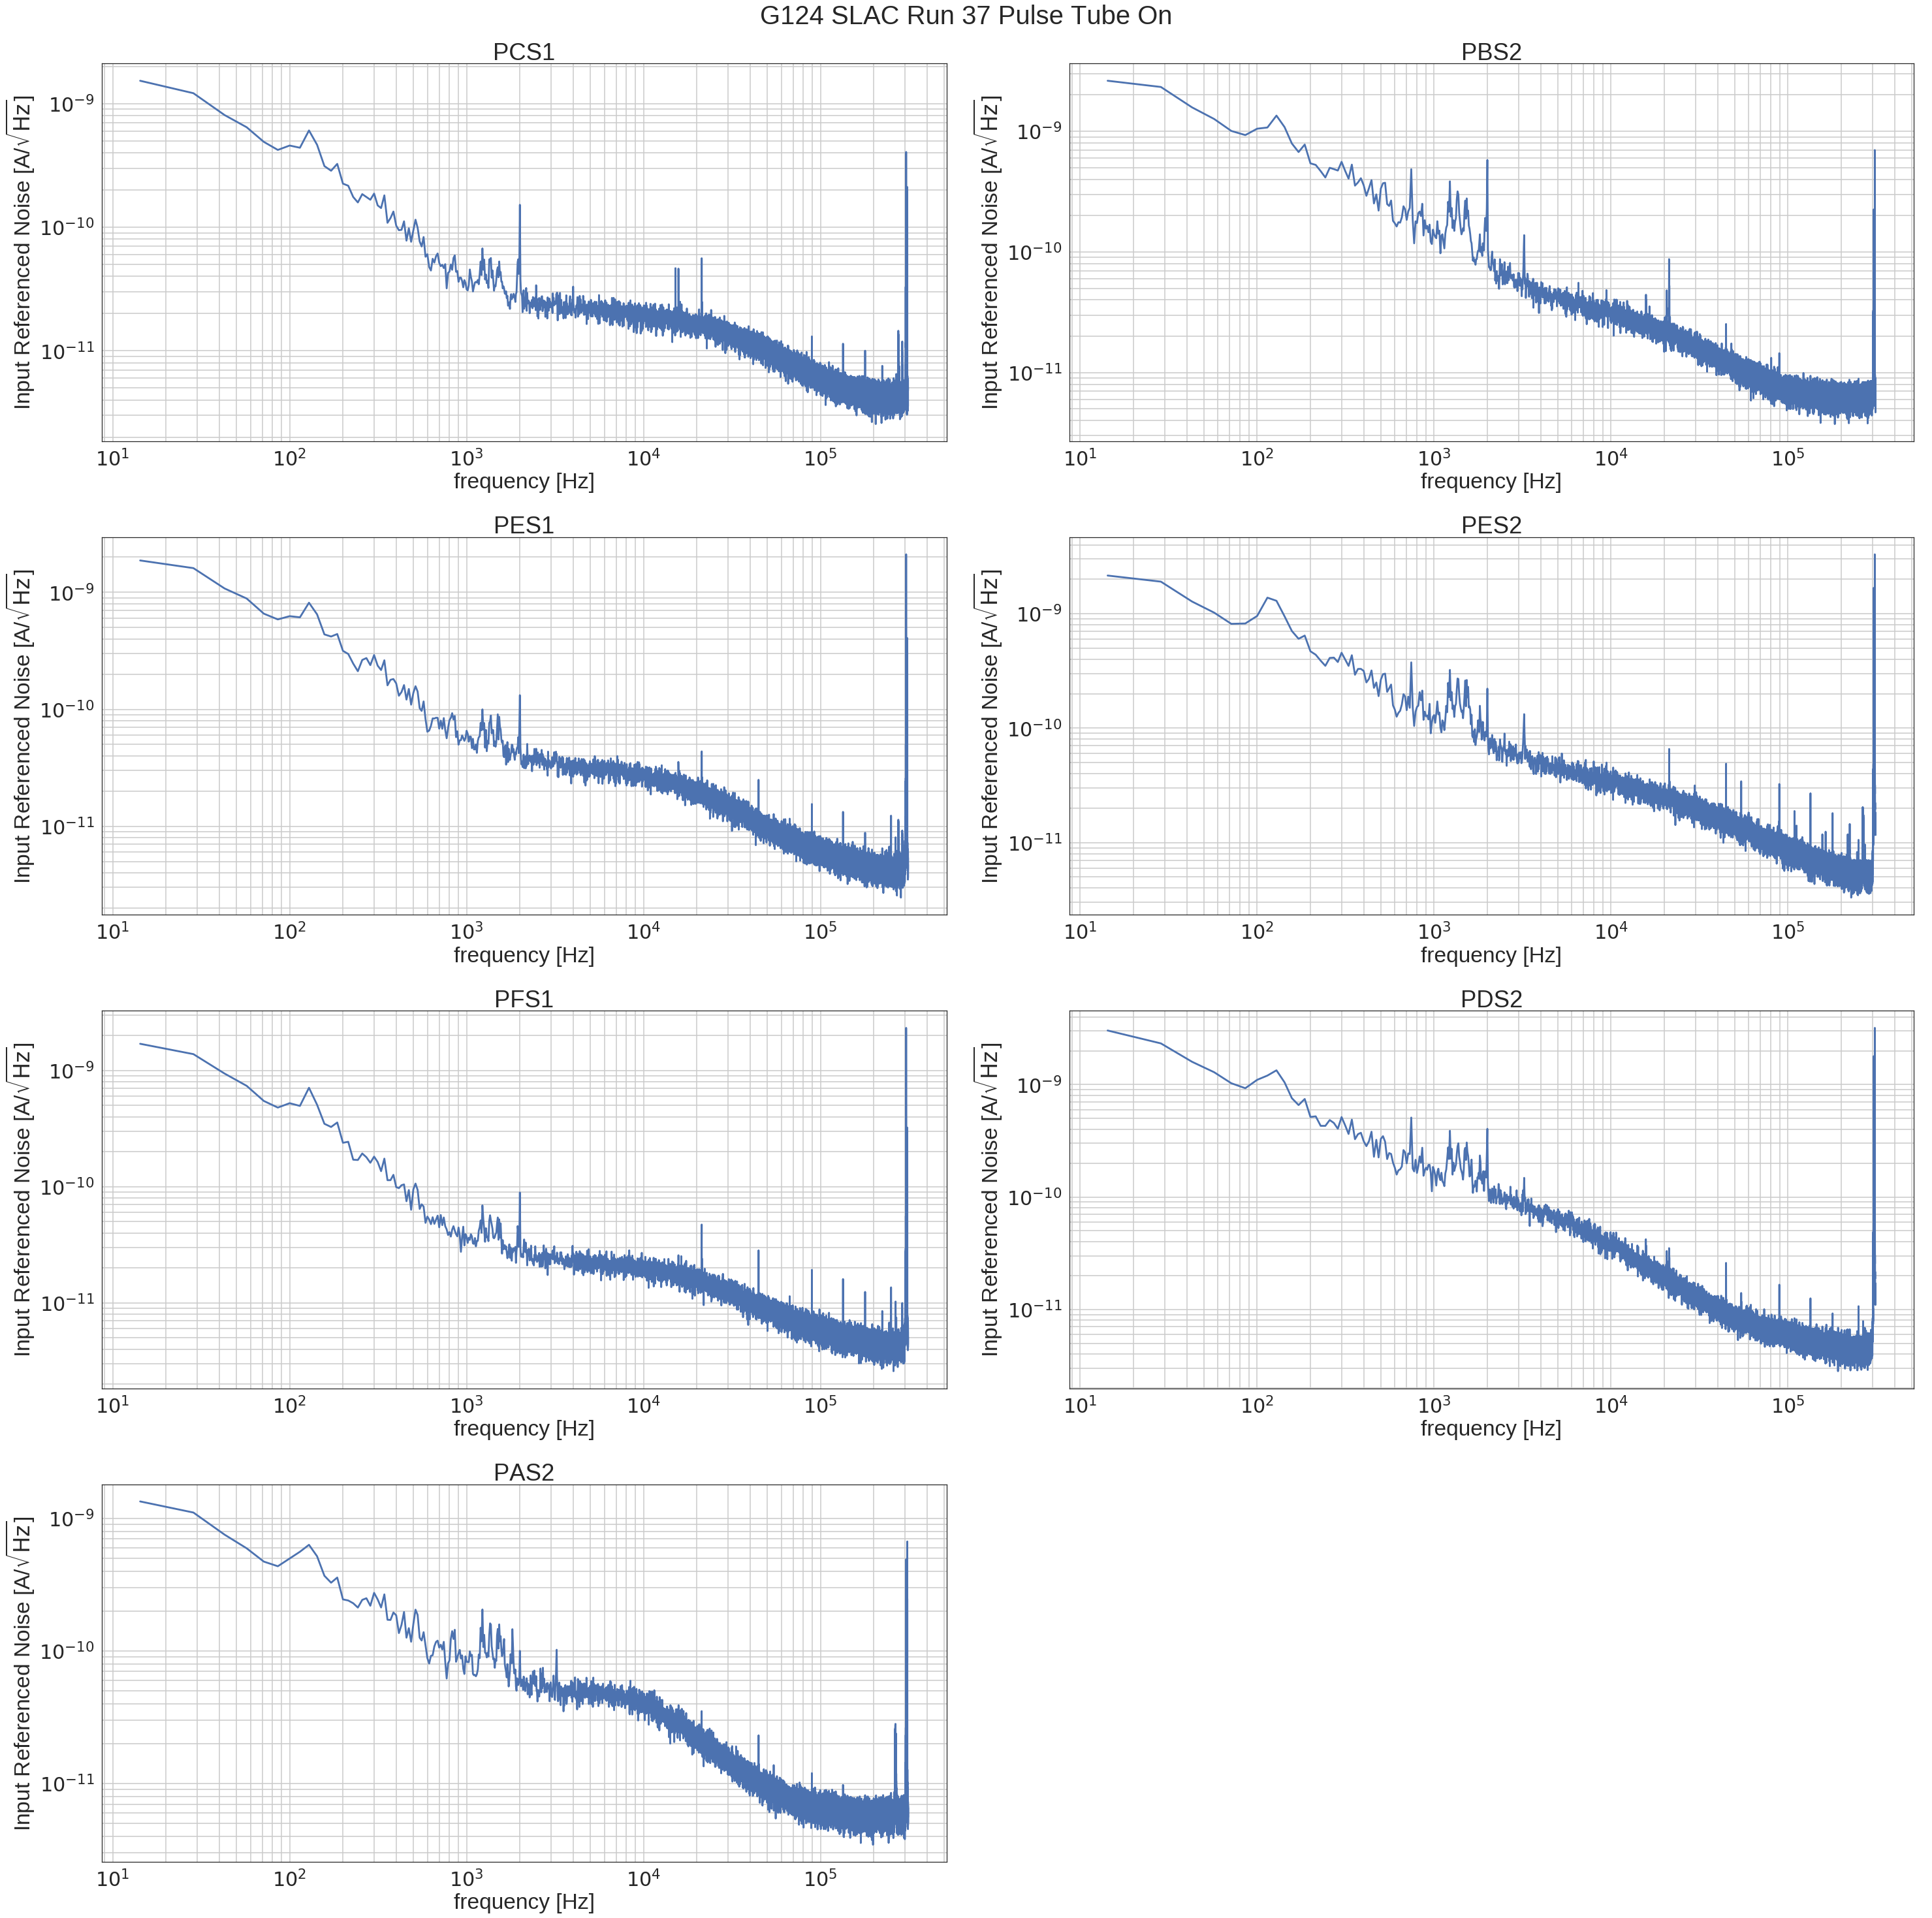

In [46]:
g124_noise.plot_PSD(lgc_overlay=False)


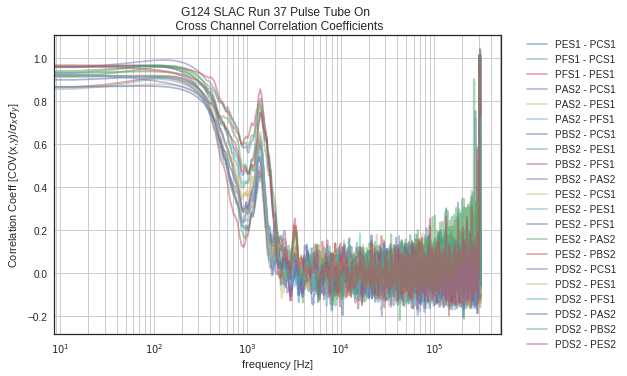

In [47]:
g124_noise.plot_corrCoef()

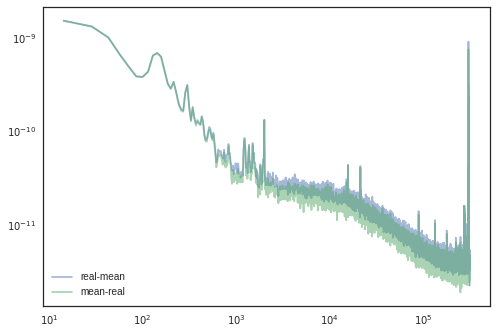

In [12]:
traceShape = g124_noise.traces.shape
nRows = traceShape[1]
nfft = traceShape[2]
nTraces = traceShape[0]
if traceShape[2] % 2 != 0:
    nFreqs = int((traceShape[2] + 1)/2)
else:
    nFreqs = int(traceShape[2]/2 + 1)
a = csd(g124_noise.traces[:,0,:],g124_noise.traces[:,1,:], nperseg = nfft, fs = g124_noise.sampleRate, nfft = nfft)
plt.loglog(a[0],np.sqrt(np.real(np.std(a[1], axis = 0))), label = 'real-mean', alpha = .5)
plt.loglog(a[0],np.sqrt(np.std(np.real(a[1]), axis = 0)), label = 'mean-real', alpha = .5)
#plt.loglog(g124_noise.freqs, np.sqrt(g124_noise.PSD[0]), label = 'PSD', alpha = .5)
plt.legend()

In [136]:
traceShape =254
if traceShape % 2 != 0:
    nFreqs = int((traceShape + 1)/2)
else:
    nFreqs = int((traceShape)/2 + 1)
nFreqs

128

In [146]:
(260/2)+1


131.0

In [138]:
254%2

0